In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:

# Define the Gaussian function to integrate
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))

# Define the QNode for the Grover operator
def grover_operator(params, wires):
    qml.Hadamard(wires=wires)
    qml.DiagonalQubitUnitary(diag_params=params, wires=wires[:-1])
    qml.Hadamard(wires=wires[-1])
    qml.MultiControlledX(control=wires[:-1], target=wires[-1])
    qml.Hadamard(wires=wires[-1])
    qml.DiagonalQubitUnitary(diag_params=params, wires=wires[:-1])
    qml.Hadamard(wires=wires)

# Define the QNode for the QAE algorithm
def qae_algorithm(integrand, n, t, a, b):
    # Create the Quantum Circuit
    dev = qml.device("default.qubit", wires=n+t)
    @qml.qnode(dev)
    def circuit(params):
        # Apply Hadamard gates to the counting qubits
        for wire in range(t):
            qml.Hadamard(wire)
        
        # Apply the Grover operator t times
        for _ in range(t):
            grover_operator(params, wires=range(n+t))

        # Measure the counting qubits
        return [qml.expval(qml.PauliZ(wire)) for wire in range(t)]

    # Define the range of integration
    x_values = np.linspace(a, b, 2**n)

    # Evaluate the integrand on the grid
    integrand_values = np.array([integrand(x, mu=0, sigma=1) for x in x_values])

    # Normalize the integrand values
    norm = np.linalg.norm(integrand_values)
    normed_integrand_values = integrand_values / norm

    # Prepare the parameters for the Grover operator
    diag_params = 2 * np.arcsin(normed_integrand_values)

    # Run the QAE algorithm
    return circuit(params=diag_params)

# Define the parameters
n = 3   # Number of input qubits
t = 2   # Number of counting qubits
a = -3  # Lower limit of integration
b = 3   # Upper limit of integration

# Run QAE
result = qae_algorithm(gaussian, n, t, a, b)

# Calculate the integral
integral = (b - a) * result / (2**t)

# Print the result
print("Approximated integral:", integral)


ValueError: Hadamard: wrong number of wires. 5 wires given, 1 expected.

In [54]:
import numpy as np
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import QasmSimulator

# Define the Gaussian function to integrate
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))

# Define the Grover operator
def grover_operator(circuit, n):
    for qubit in range(n):
        circuit.h(qubit)
    for qubit in range(n):
        circuit.x(qubit)
    circuit.h(n-1)
    #circuit.mct(list(range(n-1)), n-1)
    circuit.h(n-1)
    for qubit in range(n):
        circuit.x(qubit)
    for qubit in range(n):
        circuit.h(qubit)

# Define the QAE algorithm
def qae_algorithm(integrand, n, t, a, b):
    # Create the Quantum Circuit
    circuit = QuantumCircuit(n+t, t)

    # Apply Hadamard gates to the counting qubits
    for qubit in range(t):
        circuit.h(qubit)

    # Apply the Grover operator t times
    for _ in range(t):
        grover_operator(circuit, n)

    # Measure the counting qubits
    circuit.measure(list(range(t)), list(range(t)))

    # Run the circuit
    backend = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(circuit, backend)
    qobj = assemble(transpiled_circuit)
    result = backend.run(qobj).result()
    counts = result.get_counts()

    # Calculate the integral
    integral = 0
    for key, value in counts.items():
        x = int(key, 2) / (2**t) * (b - a) + a
        integral += value * gaussian(x, mu=0, sigma=0.2)

    return integral / (2**t)

# Define the parameters
n = 5  # Number of input qubits
t = 5   # Number of counting qubits
a = -2  # Lower limit of integration
b = 2   # Upper limit of integration

# Run QAE
result = qae_algorithm(gaussian, n, t, a, b)

# Print the result
print("Approximated integral: ", result)


Approximated integral:  7.670063924075269


/var/folders/h3/vjhmbnvx55967hlvnsshwr5m0000gn/T/ipykernel_98950/665413750.py:44: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = backend.run(qobj).result()


# Quantum phase estimation

In [1]:
import pennylane as qml
import numpy as np
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
### We need to construct the U operator to create the phase of the measured state 
def U(wires):
    return qml.PhaseShift(2 * np.pi /5, wires=wires)

In [48]:
dev = qml.device("default.qubit", wires=5, shots=10000)

@qml.qnode(dev)
def circuit_qpe(estimation_wires):
    # initialize to state |1>
    qml.PauliX(wires=len(estimation_wires))

    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    qml.ControlledSequence(U(wires=len(estimation_wires)), control=estimation_wires) ## Construct the Fourier transformation on the constructed phase

    qml.adjoint(qml.QFT)(wires=estimation_wires) #apply the inverse of Fourier transformation

    return qml.probs(wires=estimation_wires)

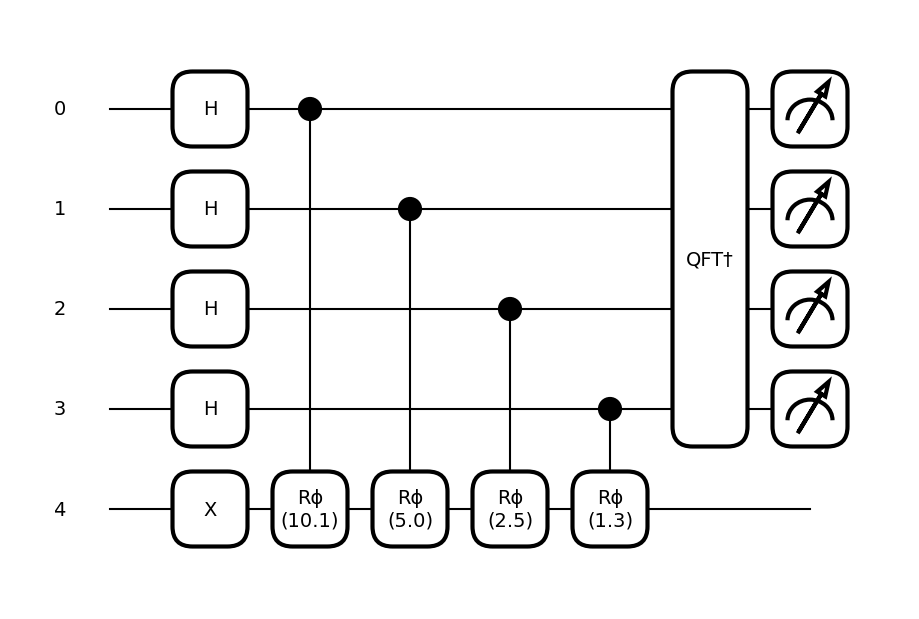

In [49]:
qml.draw_mpl(circuit_qpe,expansion_strategy='device',decimals=1,style='black_white')(range(0, 4));


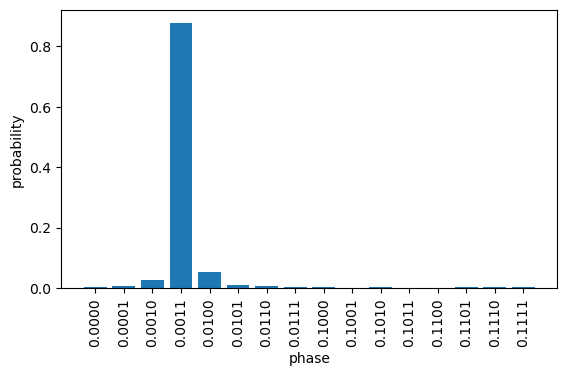

In [55]:
import matplotlib.pyplot as plt

estimation_wires = range(0, 4)

results = circuit_qpe(estimation_wires)

bit_strings = [f"0.{x:0{len(estimation_wires)}b}" for x in range(len(results))]

plt.bar(bit_strings, results)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)